In [1]:
%matplotlib inline

In [2]:
import numpy as np
import scipy as sp
from scipy import interpolate, integrate
from matplotlib import pyplot as plt
from matplotlib import rc
import matplotlib as mpl
rc('font',size=18)

In [155]:
NDIM = 3

In [135]:
rin = 0
rout = 5
#rout = 200
N1D = 200
grid1d = np.linspace(rin, rout, N1D)
dr1d = grid1d[1] - grid1d[0]

In [494]:
def pseudo2(r, dr):
    return np.maximum(dr*dr*np.ones_like(r), r**2)

def make_X_global(bounds, nx):
    xf_global = []
    xc_global = []
    dx = []
    for i in range(NDIM):
        xf = np.linspace(bounds[i][0],bounds[i][1],nx[i]+1)
        xc = 0.5*(xf[1:] + xf[:-1])
        dx.append(xf[1] - xf[0])
        xf_global.append(xf)
        xc_global.append(xc)
    Xf_global = np.meshgrid(*xf_global, indexing='ij')
    Xc_global = np.meshgrid(*xc_global, indexing='ij')
    
    return Xf_global, Xc_global, dx

def make_X_blocks(Xf_global, Xc_global, nx, nb):
    nx_b = [n//d for n,d in zip(nx,nb)]
    Xf_blks = np.empty((nb[0],nb[1],nb[2],NDIM,nx_b[0]+1,nx_b[1]+1,nx_b[2]+1))
    Xc_blks = np.empty((nb[0],nb[1],nb[2],NDIM,nx_b[0],nx_b[1],nx_b[2]))
    for ib in range(nb[0]):
        for jb in range(nb[1]):
            for kb in range(nb[2]):
                for d in range(NDIM):
                    Xf_blks[ib,jb,kb,d] = Xf_global[d][nx_b[0]*ib:nx_b[0]*(ib+1)+1,
                                                       nx_b[1]*jb:nx_b[1]*(jb+1)+1,
                                                       nx_b[2]*kb:nx_b[2]*(kb+1)+1]
                    Xc_blks[ib,jb,kb,d] = Xc_global[d][nx_b[0]*ib:nx_b[0]*(ib+1),
                                                       nx_b[1]*jb:nx_b[1]*(jb+1),
                                                       nx_b[2]*kb:nx_b[2]*(kb+1)]
    return Xf_blks, Xc_blks, nx_b

def refine_block(Xf, Xc):
    nb = (2, 2, 2)
    nx = (nb[0]*Xc.shape[1], nb[1]*Xc.shape[2], nb[2]*Xc.shape[3])
    nx_b = Xc.shape[1:]
    bounds = [[Xf[0,:,0,0].min(), Xf[0,:,0,0].max()],
              [Xf[1,0,:,0].min(), Xf[1,0,:,0].max()],
              [Xf[2,0,0,:].min(), Xf[2,0,0,:].max()]]
    Xf_global, Xc_global, nx = make_X_global(bounds,nx)
    Xf_new = []
    Xc_new = []
    for ib in range(nb[0]):
        for jb in range(nb[1]):
            for kb in range(nb[2]):
                Xf_loc = []
                Xc_loc = []
                for d in range(NDIM):
                    Xf_loc.append(Xf_global[d][nx_b[0]*ib:nx_b[0]*(ib+1)+1,
                                               nx_b[1]*jb:nx_b[1]*(jb+1)+1,
                                               nx_b[2]*kb:nx_b[2]*(kb+1)+1])
                    Xc_loc.append(Xc_global[d][nx_b[0]*ib:nx_b[0]*(ib+1),
                                               nx_b[1]*jb:nx_b[1]*(jb+1),
                                               nx_b[2]*kb:nx_b[2]*(kb+1)])
                Xf_new.append(np.stack(Xf_loc))
                Xc_new.append(np.stack(Xc_loc))
    return Xf_new, Xc_new

def refine_and_flatten_blocks(Xf_blks, Xc_blks, blocks_to_refine = None):
    Xf_out = []
    Xc_out = []
    for ib in range(Xc_blks.shape[0]):
        for jb in range(Xc_blks.shape[1]):
            for kb in range(Xc_blks.shape[2]):
                if blocks_to_refine is not None and [ib,jb,kb] in blocks_to_refine:
                    Xf_new, Xc_new = refine_block(Xf_blks[ib,jb,kb],Xc_blks[ib,jb,kb])
                    Xf_out += Xf_new
                    Xc_out += Xc_new
                else:
                    Xf_out.append(Xf_blks[ib,jb,kb])
                    Xc_out.append(Xc_blks[ib,jb,kb])
    return np.stack(Xf_out), np.stack(Xc_out)

def spherically_average(y_monopole, y_blks, Xf_blks, Xc_blks, grid1d, nx_b, cell_fac = 3):
    # r^2 sin(th) dth dph y
    r_blks = Xc_blks[:,0,:,:,:]
    th_blks = Xc_blks[:,1,:,:,:]
    ph_blks = Xc_blks[:,2,:,:,:]
    dr1d = grid1d[1] - grid1d[0]
    
    # cell widths defined at faces
    dr_blks  = Xf_blks[:,0,1:,:,:] - Xf_blks[:,0,:-1,:,:]
    dth_blks = Xf_blks[:,1,:,1:,:] - Xf_blks[:,1,:,:-1,:]
    dph_blks = Xf_blks[:,2,:,:,1:] - Xf_blks[:,2,:,:,:-1]
    
    # cell widths defined at cell centers
    dr_blks  = 0.25*(dr_blks[:,:,1:,1:] + dr_blks[:,:,:-1,:-1] 
                     + dr_blks[:,:,1:,:-1] + dr_blks[:,:,:-1,1:])
    dth_blks = 0.25*(dth_blks[:,1:,:,1:] + dth_blks[:,:-1,:,:-1]
                     + dth_blks[:,1:,:,:-1] + dth_blks[:,:-1,:,1:])
    dph_blks = 0.25*(dph_blks[:,1:,1:,:] + dph_blks[:,:-1,:-1,:]
                     + dph_blks[:,1:,:-1,:] + dph_blks[:,:-1,1:,:])
    
    drmin = dr_blks.min()
    y_integrand_blks = r_blks*r_blks*np.sin(th_blks)*dth_blks*dph_blks*y_blks
    y_integrand_blks_alt = ((3*drmin)**2)*np.sin(th_blks)*dth_blks*dph_blks*y_blks
    div_fac = 4*np.pi*pseudo2(grid1d,3*drmin)*drmin
    
    y_avgd = np.zeros_like(y_monopole)
    numblocks = Xc_blks.shape[0]
    for ib in range(numblocks):
        for i in range(nx_b[0]):
            for j in range(nx_b[1]):
                for k in range(nx_b[2]):
                    r0 = r_blks[ib,i,j,k]
                    y0_base = y_integrand_blks[ib,i,j,k]
                    y0_alt = y_integrand_blks_alt[ib,i,j,k]                       
                    dr = dr_blks[ib,i,j,k]
                    bl = r0 - dr
                    br = r0 + dr
                    il = np.where(grid1d >= bl)[0]
                    if len(il) > 0:
                        il = il[0]
                    else:
                        il = 0
                    ir = np.where(grid1d > br)[0]
                    if len(ir) > 0:
                        ir = ir[0]
                    else:
                        ir = len(grid1d)
                    for imono in range(il, ir):
                        r = grid1d[imono]
                        y0 = (y0_alt if r <= 3*dr else y0_base)*dr
                        y_avgd[imono] += y0 if r0 <= dr/2 and r <= dr/2 else y0*(1 - np.abs(r - r0)/dr)
                            
    y_avgd /= div_fac
    y_avgd[0] = y_avgd[1]
    return y_avgd

# Container class
class SphericalAverage:
    def __init__(self, rin, rout, n1d, nx, nb,
                 blocks_to_refine = None,
                 sigma = 0.5, cell_fac = 3):
        self.rin = rin
        self.rout = rout
        self.n1d = n1d
        self.nx = nx
        self.nb = nb
        self.blocks_to_refine = blocks_to_refine
        self.sigma = sigma
        self.cell_fac = cell_fac
        
        # generate grids
        print("Generating grids")
        self.grid1d = np.linspace(rin, rout, n1d)
        self.bounds = [(rin,rout), (0, np.pi), (0, 2*np.pi)]
        self.Xf_global, self.Xc_global, self.dx = make_X_global(bounds, nx)
        Xf_blks, Xc_blks, self.nx_b = make_X_blocks(self.Xf_global, self.Xc_global, nx, nb)
        self.Xf_blks, self.Xc_blks = refine_and_flatten_blocks(Xf_blks, Xc_blks, blocks_to_refine)
        
        # generate function to interpolate
        print("Generating functions")
        self.y_monopole = np.exp(-(self.grid1d/(2*sigma))**2)
        
        # put it on the 3d mesh
        y_monopole_interp = interpolate.interp1d(self.grid1d,self.y_monopole)
        self.y_blks = y_monopole_interp(self.Xc_blks[:,0,:,:,:])
        
        # average it back on to the 1d mesh
        print("Interpolating")
        self.y_avgd = spherically_average(self.y_monopole,self.y_blks, self.Xf_blks, self.Xc_blks, self.grid1d, self.nx_b)
        print("Done")

In [495]:
savg = SphericalAverage(0, 5, 200, [16, 16, 16], [2, 2, 2], [[0,0,0],[0,1,0],[0,0,1],[0,1,1]])

Generating grids
Generating functions
Interpolating
Done


In [496]:
savg.dx

[0.3125, 0.19634954084936207, 0.39269908169872414]

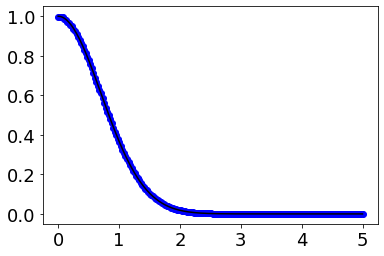

In [497]:
plt.plot(savg.grid1d,savg.y_avgd,'bo')
plt.plot(savg.grid1d,savg.y_monopole,'k-')

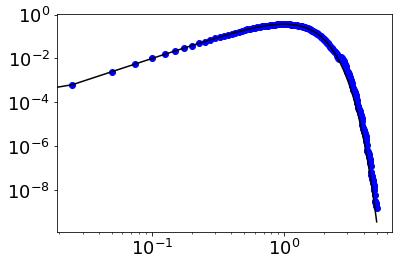

In [498]:
plt.loglog(savg.grid1d,savg.grid1d*savg.grid1d*savg.y_avgd,'bo')
plt.plot(savg.grid1d,savg.grid1d*savg.grid1d*savg.y_monopole,'k-')

6.849499e-03
6.102500e-03


Text(0, 0.5, 'error')

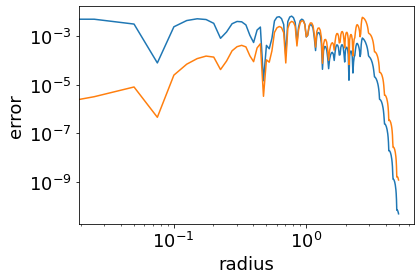

In [499]:
delta_y = savg.y_avgd - savg.y_monopole
err = np.minimum(np.abs(delta_y),np.abs(delta_y)/(savg.y_monopole + 1e-12))
print('%e' % err.max())
plt.loglog(savg.grid1d, err,label='in density')

delta_y = savg.grid1d*savg.grid1d*(savg.y_avgd - savg.y_monopole)
err = np.minimum(np.abs(delta_y),np.abs(delta_y)/(grid1d*grid1d*y_monopole + 1e-12))
print('%e' % err.max())
plt.loglog(savg.grid1d, err,label='in mass/shell')

plt.xlabel('radius')
plt.ylabel('error')

In [500]:
mass_avgd = integrate.trapz(4*np.pi*savg.grid1d**2*savg.y_avgd,x=savg.grid1d)
mass_orig = integrate.trapz(4*np.pi*grid1d**2*y_monopole,x=grid1d)
print("%e %e %e" % (mass_avgd, mass_orig, (mass_avgd - mass_orig)/mass_orig))

5.584303e+00 5.568328e+00 2.868834e-03


In [501]:
%pwd

'/mnt/hgfs/host/programming/phoebus/scripts/jupyter'

Generating grids
Generating functions
Interpolating
Done
Generating grids
Generating functions
Interpolating
Done
Generating grids
Generating functions
Interpolating
Done
Generating grids
Generating functions
Interpolating
Done


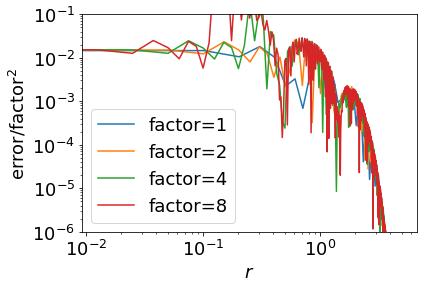

In [505]:
n1d_base = 50
nblk_base = 16
max_errs = []
mass_errs = []
resfacs = [1,2,4,8]
for resfac in resfacs:
    savg = SphericalAverage(0, 5, n1d_base*resfac, 
                            [nblk_base*resfac,nblk_base*resfac,nblk_base*resfac], 
                            [2, 2, 2])
    delta_y = savg.y_avgd - savg.y_monopole
    err = np.minimum(np.abs(delta_y),np.abs(delta_y)/(savg.y_monopole + 1e-12))
    max_errs.append(err.max())
    mass_avgd = integrate.trapz(4*np.pi*savg.grid1d**2*savg.y_avgd,x=savg.grid1d)
    mass_orig = integrate.trapz(4*np.pi*grid1d**2*y_monopole,x=grid1d)
    mass_errs.append((mass_avgd - mass_orig)/mass_orig)
    plt.loglog(savg.grid1d, (resfac**2)*err,label=f'factor={resfac}')
plt.legend()
plt.xlabel(r'$r$')
plt.ylabel(r'error$/$factor$^2$')
plt.ylim(1e-6,1e-1)

plt.savefig('interpolation_error_gaussian_spherical_3d_multiblock.png',
            bbox_inches='tight',
            dpi=300)

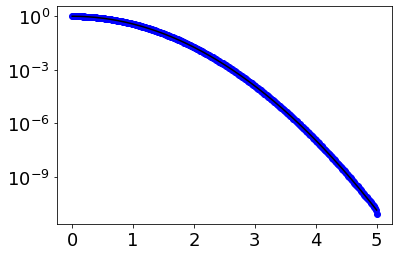

In [506]:
plt.semilogy(savg.grid1d,savg.y_avgd,'bo')
plt.plot(savg.grid1d,savg.y_monopole,'k-')

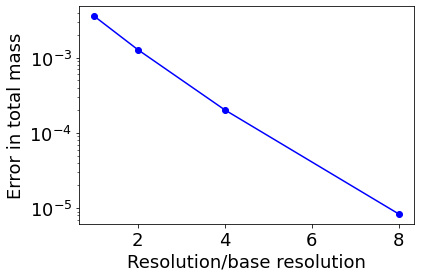

In [507]:
plt.semilogy(resfacs,np.abs(mass_errs),'bo-')
plt.xlabel('Resolution/base resolution')
plt.ylabel('Error in total mass')
plt.savefig('interpolation_mass_error_amr_spherical_3d_multiblock.png',bbox_inches='tight',dpi=300)

In [378]:
%ls

interpolation_error_gaussian_spherical_3d_multiblock_unigrid.png
interpolation_mass_error_no_amr_spherical_3d_multiblock_unigrid.png
monpole-test.ipynb
monpole-tov-test.ipynb
remapping-toy.ipynb
tov-hydro.ipynb
TOV.ipynb
tov-rhs.ipynb
